## Brainstorming
#### Analysis Questions 
- How many temperature readings in each month seemed inaccurate
    - I defined the outliers as being 2 standard deviations above or below the mean

#### Data Quality Assessment
- **First**:
    - Renaming all the columns to a shorter, simplified name
    - Needing to use `FAWN_raw.columns = FAWN_raw.columns.str.strip()` to make all the white spaces between letters, numbers, or symbols single spaces so all the spaces are uniform  
- Check data types using `.info()`
    - displays: Column names, types, non-null counts, memory
- Check statistical description using `.describe()`  
- Use `.value_counts()` for frequency count of each category (**need to do**)
- Finding outliers for max and min temperatures   
    - find `std()` for max and min temperatures, by month, for all three years using `groupby()`  

#### Analysis 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy import stats

# loading Dataset from a CSV file #
FAWN_raw_initial = pd.read_csv("data/FAWN_report.csv")

FAWN_raw = pd.read_csv("data/FAWN_report.csv", parse_dates=["Period"], date_format="%d-%b-%y")
FAWN_clean = FAWN_raw
# FAWN_raw_spaces = FAWN_raw.columns.tolist()

# Cleaning raw data set
FAWN_clean.columns = FAWN_raw.columns.str.replace("  ", " ")

FAWN_clean.rename(
    columns={
        "2m T avg (F)": "Temp_avg (F)",
        "2m T min (F)": "T_min (F)",
        "2m T max (F)": "T_max (F)",
        "2m DewPt avg (F)": "DewPt_avg (F)",
        "RelHum avg 2m (pct)": "RelHum_avg (pct)",
        "2m Rain tot (in)": "Rain_tot (in)",
        "2m Rain max over 15min (in)": "Rain_max over 15min (in)",
        "SolRad avg2m (w/m^2)": "SolRad_avg @ 2m (w/m^2)",
        "10m Wind avg (mph)": "Wind_avg @ 10m (mph)",
        "10m Wind min (mph)": "Wind_min @ 10m (mph)",
        "10m Wind max (mph)": "Wind_max @ 10m (mph)",
        "WDir avg10m (deg)": "Wind_Dir_avg @ 10m (deg)",
        "BP avg (mb)": "Barametric_Pre_avg (mb)",
        "N (# obs)": "N (#obs)",
        "2m WetBulb (F)": "WetBulb @ 2m (F)",
    },
    inplace=True,
)


# FAWN_raw = FAWN_raw.replace('0', np.nan)
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

#print(f"{FAWN_clean.isna().sum()}\n")

# print(f"{FAWN_raw_spaces}\n")
# print(f"{FAWN_raw.columns}\n")

# Quality Assessment 
print(f"\n{FAWN_clean.dtypes}\n")
print(f"\n{FAWN_clean.info()}\n")
print(f"{FAWN_raw.describe()}\n")
print(f"Shape/dimensions of DataFrame: {FAWN_clean.shape}\n")
print(f"Number of ElemenFts: {FAWN_clean.size}\n")
# print(f"Number of Elements: {FAWN_clean['Period'].dt.month}

# Finding min temp outliers by month
FAWN_clean["Month"] = FAWN_clean["Period"].dt.month_name()
monthyly_std_T_min = FAWN_clean.groupby("Month")["T_min (F)"].std() * 2
monthyly_mean_T_min = FAWN_clean.groupby("Month")["T_min (F)"].mean()
print(f"Two times Std: \n{monthyly_std_T_min}\n")
print(f"Mean of each month: \n{monthyly_mean_T_min}\n")

# Creating a separate column for Days 
FAWN_clean["Day"] = FAWN_clean["Period"].dt.day_name()
# daily_T_min_byMonth = FAWN_clean.groupby('Month').agg({'Day':

# Calculating two std dev values above and below the mean for each month 
two_std_overMean = monthyly_std_T_min + monthyly_mean_T_min
two_std_underMean = monthyly_mean_T_min - monthyly_std_T_min
print(f"Two std above Mean: \n{two_std_overMean}\n")
print(f"Two std below Mean: \n{two_std_underMean}\n") 

"""FAWN_clean.merge(
    two_std_underMean.rename('Two std above Temp_min Mean'), 
    left_on=FAWN_clean['Month'], 
    right_index=True, 
    how='left'
)"""

# Adding two std dev values above and below the mean for each month 
FAWN_clean["Two std above Temp_min Mean"] = FAWN_clean["Month"].map(two_std_overMean)
FAWN_clean["Two std below Temp_min Mean"] = FAWN_clean["Month"].map(two_std_underMean)

# Setting Period as index 
FAWN_clean = FAWN_clean.set_index("Period")

# Finding Outliers 
Temp_min_outlier = FAWN_clean[
    (FAWN_clean["T_min (F)"] > FAWN_clean["Two std above Temp_min Mean"])
    | (FAWN_clean["T_min (F)"] < FAWN_clean["Two std below Temp_min Mean"])
]
# print(Temp_min_outlier.count())

FAWN_clean.head(40)
print(f"\nNumber of outliers: \n{Temp_min_outlier['T_min (F)']}")


FAWN Station                        object
Period                      datetime64[ns]
Temp_avg (F)                       float64
T_min (F)                          float64
T_max (F)                          float64
DewPt_avg (F)                      float64
RelHum_avg (pct)                     int64
Rain_tot (in)                      float64
Rain_max over 15min (in)           float64
SolRad_avg @ 2m (w/m^2)            float64
Wind_avg @ 10m (mph)               float64
Wind_min @ 10m (mph)               float64
Wind_max @ 10m (mph)               float64
Wind_Dir_avg @ 10m (deg)             int64
Barametric_Pre_avg (mb)              int64
N (#obs)                             int64
WetBulb @ 2m (F)                   float64
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6572 entries, 0 to 6571
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   FAWN Station     

#### Histogram of Minimum Temp values **by** month
- Graph the minimum temperature value for each day by month
- Should give you 12 graphs 
    - Label two std deviations above **and** below the mean on **each** graph 
- `Temp_min_outlier = FAWN_clean[ (FAWN_clean["T_min (F)"] > FAWN_clean["Two std above Temp_min Mean"])
    | (FAWN_clean["T_min (F)"] < FAWN_clean["Two std below Temp_min Mean"])]`
    - Try to use this variable, `Temp_min_outlier`, to highlight the outliers on the graph 


NameError: name 'stats' is not defined

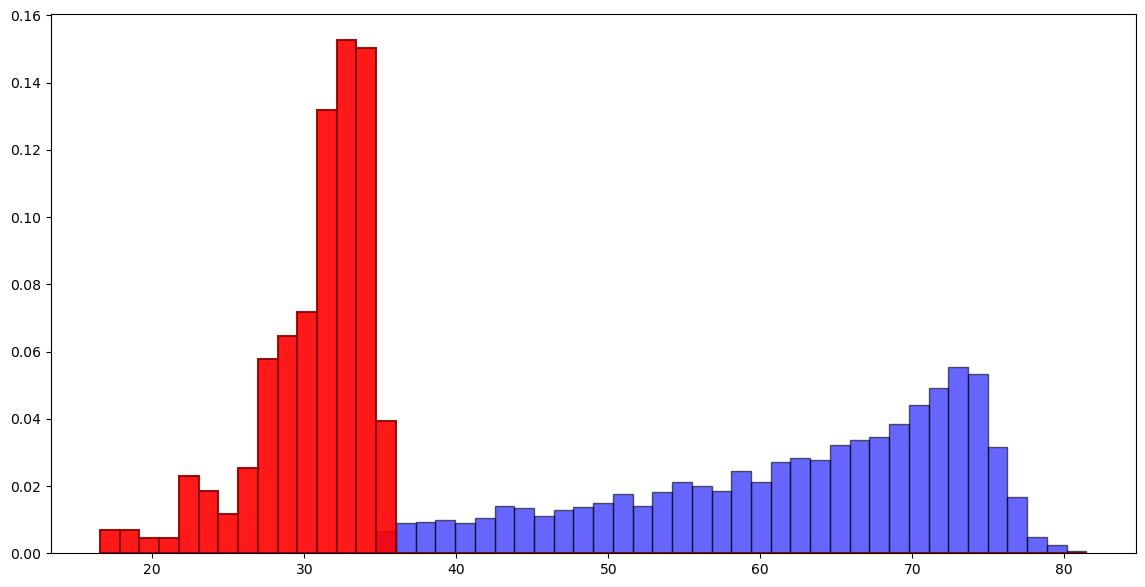

In [6]:
# To create a column for the Temp_min_outlier for the entire dataset
# calculate the 2 standard deviation boundaries for each month
monthly_stat = FAWN_clean.groupby("Month")["T_min (F)"].agg(["mean", "std"]).reset_index()
monthly_stat["upper_bound"] = monthly_stat["mean"] + 2 * monthly_stat["std"]
monthly_stat["lower_bound"] = monthly_stat["mean"] - 2 * monthly_stat["std"]

# finally, let us create the outlier column
FAWN_clean["Temp_min_outlier"] = (FAWN_clean["T_min (F)"] > FAWN_clean["upper_bound"]) | (
    FAWN_clean["T_min (F)"] < FAWN_clean["lower_bound"]
)

# To create the subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# To get unique months
months = FAWN_clean["Month"].unique()
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dex"]

# Now let's loop through each month
for idx, month in enumerate(sorted(months)):
    ax = axes[idx]

    # Filter data for this month
    month_data = FAWN_clean[FAWN_clean["Month"] == month].copy()

    # To get the temperature data
    temp_data = month_data["T_min (F)"].dropna()

    # To identify the outliers, i.e, values outside the 2 std from the mean
    outliers = month_data[month_data["Temp_min_outlier"] == True]["T_min (F)"].dropna()
    Non_outliers = month_data[month_data["Temp_min_outlier"] == False]["T_min (F)"].dropna()

    # To calculate the statistics
    mean_temp = temp_data.mean()
    std_temp = temp_data.std()

    # Now, let's create bins
    if len(temp_data) > 0:
        bin_edges = np.linspace(temp_data.min(), temp_data.max(), 20)

        # histogram plots for non-outliers and outliers
        ax.hist(
            Non_outliers,
            bins=bin_edges,
            alpha=0.6,
            color="blue",
            label="Non_outliers",
            density=True,
            edgecolor="black",
        )
        if len(outliers) > 0:
            ax.hist(
                outliers,
                bins=bin_edges,
                alpha=0.9,
                color="red",
                label="outliers",
                density=True,
                edgecolor="darkred",
                linewidth=1.5,
            )

            # let add normal distribution curve
            x = np.linspace(temp_data.min(), temp_data.max(), 100)
            normal_curve = stats.norm.pdf(x, mean_temp, std_temp)
            ax.plot(x, normal_curve, "green", linewidth=2, label="Normal distribution")

            # Let's add a vertical line for the mean
            ax.axvline(mean_temp, color="black", linestyle="--", linewidth=1.5, alpha=0.7)

            # Define the outliers and non-outliers
            upper_bound = mean_temp + 2 * std_temp
            lower_bound = mean_temp - 2 * std_temp
            ax.axvline(upper_bound, color="orange", linestyle="--", linewidth=1, alpha=0.5)
            ax.axvline(lower_bound, color="red", linestyle="--", linewidth=1, alpha=0.5)

        # Let label and give title to the plot's
        ax.set_xlabel("Temperature in Fahrenheit", fontsize=10, fontweight="bold")
        ax.set_ylabel("Density", fontsize=10, fontweight="bold")
        ax.set_title(f"{month_names[idx]} (Mont)", fontsize=12, fontweight="bold")
        ax.legend(loc="upper right", fontsize=8)
        ax.grid(True, alpha=0.3)

plt.suptitle(
    "Distribution off minimum temperature with outliers by month\n(2 standard deviation)",
    fontsize=14,
    fontweight="bold",
    y=0.995,
)

plt.tight_layout()
plt.show()